In [1]:
import cv2
import imutils
import os
import numpy as np
import pading_the_grain
from lib.utils import *
PATH = 'ENLARGED_TRAINABLE_DATASET'
label_encoder = {}
label_decoder = {}
w=0.90
i = 0
for grain_type in os.listdir(PATH):
  

  
  label_encoder[str(grain_type)] = i
  label_decoder[i] = grain_type
  i+=1
ac=[]
print(label_encoder)
print(label_decoder)



{'Sugandha': 0}
{0: 'Sugandha'}


In [2]:
accuracy=[]
partition = {}
partition['train'] = []
partition['validation'] = []


label = {}


for grain_type in os.listdir(PATH):
  


    
  type_path = os.path.join(PATH,grain_type)
  
  type_list = os.listdir(type_path)
  
  
  np.random.seed(10)
  
  fixed_type_list = np.random.choice(type_list, size=len(type_list), replace=False)
  
  train_list = fixed_type_list[3000:]
  validation_list = fixed_type_list[:3000]
  
  for item in train_list:
    item_path = os.path.join(type_path, item)
    partition['train'].append(item_path)
    label[item_path] = label_encoder[grain_type] 
    
  for item in validation_list:
    item_path = os.path.join(type_path, item)
    partition['validation'].append(item_path)
    label[item_path] = label_encoder[grain_type]
  
  

In [3]:
import numpy as np
import keras
import imutils

no_classes = 8
 


class DataGenerator(keras.utils.all_utils.Sequence):
    
    def __init__(self, list_IDs, labels, batch_size=64, dim=(128,128), n_channels=3,
                 n_classes=no_classes, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
         
      

    def __data_generation(self,list_IDs_temp):
        
        
        X = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

       
        for i, ID in enumerate(list_IDs_temp):
            
            try:
              _ = (cv2.imread(ID).shape!=(128,128,3))
            except:
              continue
            try:
              X[i,] = cv2.imread(ID)*(1.0/255.0)
              
            except:
              continue
                
            
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


C:\Users\VC\AppData\Local\Programs\Python\Python36\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
import numpy as np

from keras.models import Sequential

training_generator = DataGenerator(partition['train'], label)
validation_generator = DataGenerator(partition['validation'], label)


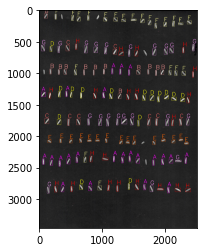

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 6)       456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)      

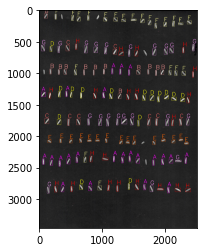

In [5]:


from keras.layers import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

model=Sequential()
input_shape=(128,128,3)
model = Sequential()

model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

img = mpimg.imread('images/predicted_img.jpg')
imgplot = plt.imshow(img)
plt.show()
model.add(Conv2D(16, (5, 5),padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(no_classes, activation = 'softmax'))

model.summary()



model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
img = mpimg.imread('images/predicted_img.jpg')
imgplot = plt.imshow(img)
plt.show()


In [6]:
import numpy as np
import keras
import imutils
import math

no_classes = 8

def generate_data(ID):

    img = cv2.imread(ID)
    img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    canny_img = cv2.Canny(img_grey, 100, 100)
      
    cnts = cv2.findContours(canny_img.copy(),  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
      
    for c in cnts:
      rect = cv2.minAreaRect(c)
      ((_, _), (p,q), _) = rect
      if(p>=q):
          length = p
          width = q
      else:
          length = q
          width = p

      area = cv2.contourArea(cnts[0])
      perimeter = cv2.arcLength(cnts[0], closed=True)
      
      try:
        (_,_), (majax, minax), _ = cv2.fitEllipse(cnts[0])
        if(ax1>=ax2):
          majax = ax1
          minax = ax2
        else:
          majax = ax2
          minax = ax1
        return [area/perimeter, area/(area+perimeter), maxax/minax, area/(length*width), math.sqrt(4*area/math.pi), area/(majax*minax)]
      
      except:
        
        return [area/perimeter, area/(area+perimeter), length/width, area/(length*width), math.sqrt(4*area/math.pi), area/(length*width)]

In [7]:
def pred(image_path):
  
  k = np.expand_dims(cv2.imread(image_path)*(1.0/255.0), axis=0)
  p = model.predict(k)
  p = np.argmax(p)
  
  return label_decoder[p]

In [8]:
x_train = []
y_train = []
x_test = []
y_test = []

PATH = 'ENLARGED_TRAINABLE_DATASET'

for grain_type in [os.listdir(PATH)[0]]:
  
  print(f"Collecting type {grain_type}")
    
  type_path = os.path.join(PATH,grain_type)
  
  type_list = os.listdir(type_path)
 
  np.random.seed(10)
  fixed_type_list = np.random.choice(type_list, size=len(type_list), replace=False)

  i = 0 
  for item in fixed_type_list:
    
    item_path = os.path.join(type_path, item)
    try:
      dat = generate_data(item_path)
      i+=1
    except:
      continue
      
    if(i%1000==0):
      print(i) 
    
    
    if(i<=3000):
      x_test.append(dat)
      y_test.append(label_encoder[grain_type])
    #print("Done with Validation")
    
    else:
      x_train.append(dat)
      y_train.append(label_encoder[grain_type])

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [9]:

X,y=scaler_transform(training_generator)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [10]:
from sklearn.svm import SVC
model=SVC(gamma='auto')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac.append((accuracy_score(y_test,y_pred,sample_weight=1))*100)

In [11]:

from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,epochs=30)

ac.append((accuracy_score(y_test,y_pred,sample_weight=0.2))*100)


Epoch 1/30
4/4 [==============================] - 1s 3ms/step - loss: 2.0677
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 1.9441
Epoch 3/30
4/4 [==============================] - 0s 3ms/step - loss: 1.8171
Epoch 4/30
4/4 [==============================] - 0s 3ms/step - loss: 1.6967
Epoch 5/30
4/4 [==============================] - 0s 3ms/step - loss: 1.5787
Epoch 6/30
4/4 [==============================] - 0s 4ms/step - loss: 1.4705
Epoch 7/30
4/4 [==============================] - 0s 2ms/step - loss: 1.3605
Epoch 8/30
4/4 [==============================] - 0s 4ms/step - loss: 1.2603
Epoch 9/30
4/4 [==============================] - 0s 3ms/step - loss: 1.1588
Epoch 10/30
4/4 [==============================] - 0s 5ms/step - loss: 1.0649
Epoch 11/30
4/4 [==============================] - 0s 2ms/step - loss: 0.9773
Epoch 12/30
4/4 [==============================] - 0s 4ms/step - loss: 0.8846
Epoch 13/30
4/4 [==============================] - 0s 2ms/step - loss: 0.

C:\Users\VC\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Agorithms,accuracy
0,SVM,95.71
1,CNN,97.27


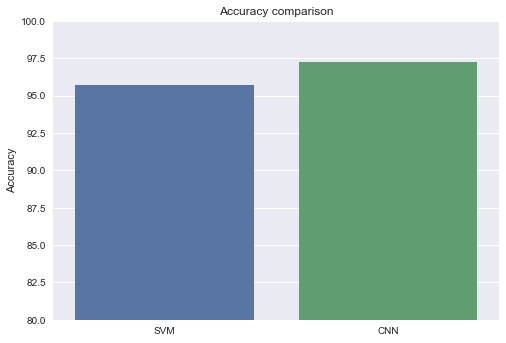

In [12]:
import numpy as np
import seaborn as sns
import matplotlib as plt
import math
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')
x=['SVM','CNN']
y=ac
ax=sns.barplot(x,y)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(80,100)
import pandas as pd
data={'Agorithms':x,
     "accuracy":ac}
df=pd.DataFrame(data)
df.head()